In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER Delhi DATA FROM ALL AVAILABLE YEARS
Delhi_Data = pd.read_csv('Delhi_data.csv', index_col=0)

In [4]:
#Delhi DATA PREVIEW
Delhi_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windspeed,winddir
2014-12-29,0.506515,0.067839,0.205493,0.506399,0.123762,0.128049,0.236842,0.815126,0.029234,0.211359
2014-12-30,0.516287,0.108040,0.319430,0.616088,0.202970,0.103659,0.240602,0.857143,0.029234,0.504673
2014-12-31,0.384365,0.183417,0.123093,0.314442,0.227723,0.164634,0.270677,0.777911,0.065524,0.210280
2015-01-01,1.000000,0.118090,0.217701,0.643510,0.405941,0.234756,0.319549,0.733493,0.020161,0.238318
2015-01-02,0.469055,0.138191,0.066124,0.259598,0.123762,0.237805,0.406015,0.847539,0.029234,0.169303
...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.179153,0.175879,0.128179,0.266910,0.252475,0.618902,0.699248,0.642257,0.065524,0.572969
2022-03-16,0.133550,0.195980,0.115972,0.246801,0.232673,0.640244,0.684211,0.589436,0.095766,0.861970
2022-03-17,0.177524,0.203518,0.130214,0.272395,0.306931,0.643293,0.706767,0.602641,0.020161,0.511503
2022-03-18,0.076547,0.278894,0.124110,0.283364,0.217822,0.658537,0.774436,0.656663,0.045867,0.338246


## Data Preparation for Univariate Models

In [5]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Delhi_Data_uni = Delhi_Data.loc[:, Delhi_Data.columns.intersection(cols)]
Delhi_Data_uni = Delhi_Data_uni.apply(pd.to_numeric, errors='coerce')

#FILL NAN VALUES
Delhi_Data_uni = Delhi_Data_uni.iloc[1: , :]

#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Delhi_Data_uni = Delhi_Data_uni.replace(r'^\s*$', np.nan, regex=True)
Delhi_Data_uni = Delhi_Data_uni.fillna(method='ffill')
Delhi_Data_uni = Delhi_Data_uni.fillna(method='bfill')

#REMOVE DUPLICATE VALUES
Delhi_Data_uni = Delhi_Data_uni[~Delhi_Data_uni.index.duplicated(keep='first')]

In [6]:
#UNIVARIATE DATA PREVIEW
Delhi_Data_uni

,no2,o3,pm10,pm25,so2
2014-12-30,0.516287,0.108040,0.319430,0.616088,0.202970
2014-12-31,0.384365,0.183417,0.123093,0.314442,0.227723
2015-01-01,1.000000,0.118090,0.217701,0.643510,0.405941
2015-01-02,0.469055,0.138191,0.066124,0.259598,0.123762
2015-01-03,0.369707,0.118090,0.083418,0.272395,0.193069
...,...,...,...,...,...
2022-03-15,0.179153,0.175879,0.128179,0.266910,0.252475
2022-03-16,0.133550,0.195980,0.115972,0.246801,0.232673
2022-03-17,0.177524,0.203518,0.130214,0.272395,0.306931
2022-03-18,0.076547,0.278894,0.124110,0.283364,0.217822


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Delhi_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windspeed', 'winddir'],
      dtype='object')

In [8]:
#SOME VALUES ARE EMPTY, BUT NOT RECOGNIZED AS NAN. REPLACE EMPTY VALUES WITH NAN TO FILL THEM LATER
Delhi_Data = Delhi_Data.replace(r'^\s*$', np.nan, regex=True)

#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Delhi_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [9]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Delhi_Data_multi = Delhi_Data.loc[:, Delhi_Data.columns.intersection(cols)]
Delhi_Data_multi = Delhi_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Delhi_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [11]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Delhi_Data_multi = Delhi_Data_multi.iloc[1: , :]
#Delhi_Data_multi = Delhi_Data_multi.fillna(method='bfill')
#Delhi_Data_multi = Delhi_Data_multi.fillna(method='ffill')
Delhi_Data_multi = Delhi_Data_multi.dropna()
(Delhi_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [12]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Delhi_o3 = Delhi_Data_multi.loc[:, Delhi_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Delhi_so2 = Delhi_Data_multi.loc[:, Delhi_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Delhi_no2 = Delhi_Data_multi.loc[:, Delhi_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Delhi_pm25 = Delhi_Data_multi.loc[:, Delhi_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Delhi_pm10 = Delhi_Data_multi.loc[:, Delhi_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Delhi_o3, Delhi_no2, Delhi_so2, Delhi_pm10, Delhi_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Delhi_o3

,o3,temp,dew,humidity,windspeed,winddir
2014-12-30,0.108040,0.103659,0.240602,0.857143,0.029234,0.504673
2014-12-31,0.183417,0.164634,0.270677,0.777911,0.065524,0.210280
2015-01-01,0.118090,0.234756,0.319549,0.733493,0.020161,0.238318
2015-01-02,0.138191,0.237805,0.406015,0.847539,0.029234,0.169303
2015-01-03,0.118090,0.246951,0.443609,0.891957,0.020161,0.537024
...,...,...,...,...,...,...
2022-03-15,0.175879,0.618902,0.699248,0.642257,0.065524,0.572969
2022-03-16,0.195980,0.640244,0.684211,0.589436,0.095766,0.861970
2022-03-17,0.203518,0.643293,0.706767,0.602641,0.020161,0.511503
2022-03-18,0.278894,0.658537,0.774436,0.656663,0.045867,0.338246


# UNIVARIATE CNN

In [14]:
def Uni_CNN():
    preds = [] 
    tests = [] 
    #n_steps = 7
    n_features = 1

    #CNN UNIVARIATE MODEL
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    for col in Delhi_Data_uni.columns:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(Delhi_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], n_features))

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(tests)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Univariate CNN MSE for Delhi[" + str(col) + "]:" + str(mse))
        print("Univariate CNN RMSE for Delhi[" + str(col) + "]:" + str(rmse))
        print("Univariate CNN MAE for Delhi[" + str(col) + "]:" + str(mae))
        #print("Univariate CNN MAPE for Delhi[" + str(col) + "]:" + str(mape))

        title = "Univariate CNN for Delhi_Data" + "[" + col +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE CNN

In [15]:
def Multi_CNN():
    preds = []
    tests = []
    
    #n_steps=7

    for data in datasets:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features= window.shape[2]

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #MULTIVARIATE CNN MODEL
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=2, input_shape=(n_steps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate CNN MSE for Delhi[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate CNN RMSE for Delhi[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate CNN MAE for Delhi[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate CNN MAPE for Delhi[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Multivariate CNN for Delhi[" + str(data.columns[0]) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    
    return preds, tests

# UNIVARIATE LSTM

In [16]:
def Uni_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for col in Delhi_Data_uni.columns:
        window, output = split_ts_by_window(Delhi_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], 1))

        #UNIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
        lstm_model.add(Dense(30,activation='relu'))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1,activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Univariate LSTM MSE for Delhi[" + str(col) + "]:" + str(mse_ucnn))
        print("Univariate LSTM RMSE for Delhi[" + str(col) + "]:" + str(rmse_ucnn))
        print("Univariate LSTM MAE for Delhi[" + str(col) + "]:" + str(mae_ucnn))
        #print("Univariate LSTM MAPE for Delhi[" + str(col) + "]:" + str(mape_ucnn))

        title = "Univariate LSTM for Delhi[" + str(col) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE LSTM

In [17]:
def Multi_LSTM():
    preds = []
    tests = []
    #n_steps=7

    for data in datasets:
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features = window.shape[2]


        #MULTIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
        lstm_model.add(Dense(30))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE RMSE FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate LSTM MSE for Delhi[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate LSTM RMSE for Delhi[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate LSTM MAE for Delhi[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate LSTM MAPE for Delhi[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Mutlivariate LSTM for Delhi" + "[" + str(data.columns[0]) +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

Univariate CNN MSE for Delhi[no2]:0.0024389564
Univariate CNN RMSE for Delhi[no2]:0.04938579153934332
Univariate CNN MAE for Delhi[no2]:0.038335837


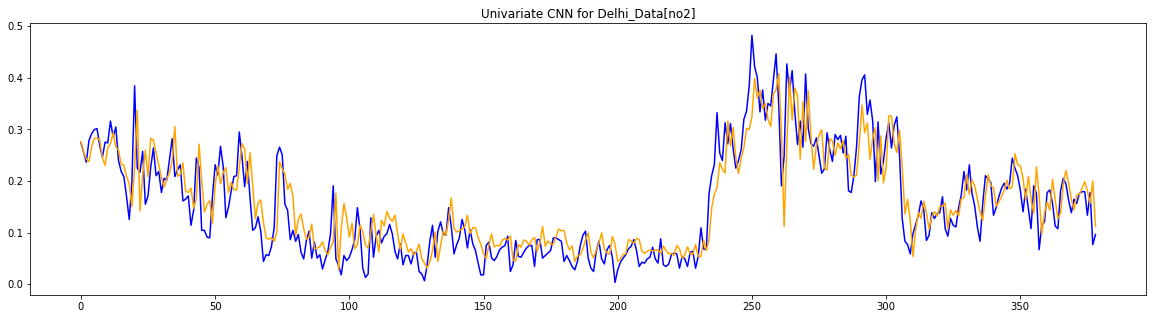

Univariate CNN MSE for Delhi[o3]:0.004825831
Univariate CNN RMSE for Delhi[o3]:0.06946820082063457
Univariate CNN MAE for Delhi[o3]:0.05214519


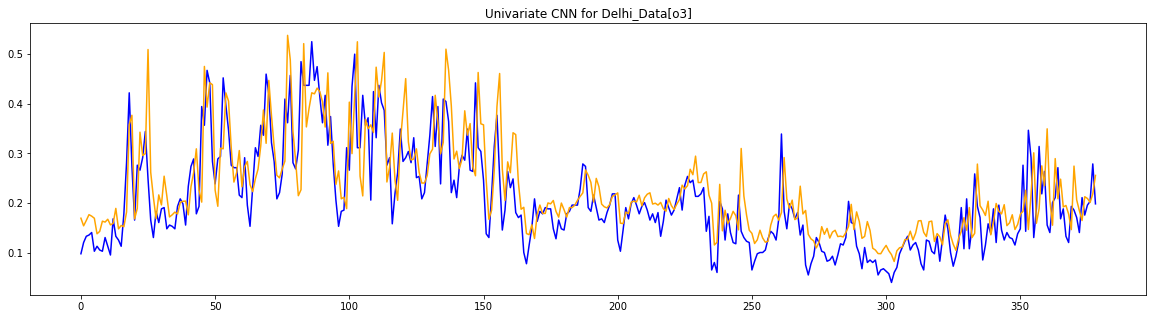

Univariate CNN MSE for Delhi[pm10]:0.002378758
Univariate CNN RMSE for Delhi[pm10]:0.048772513191866235
Univariate CNN MAE for Delhi[pm10]:0.028880686


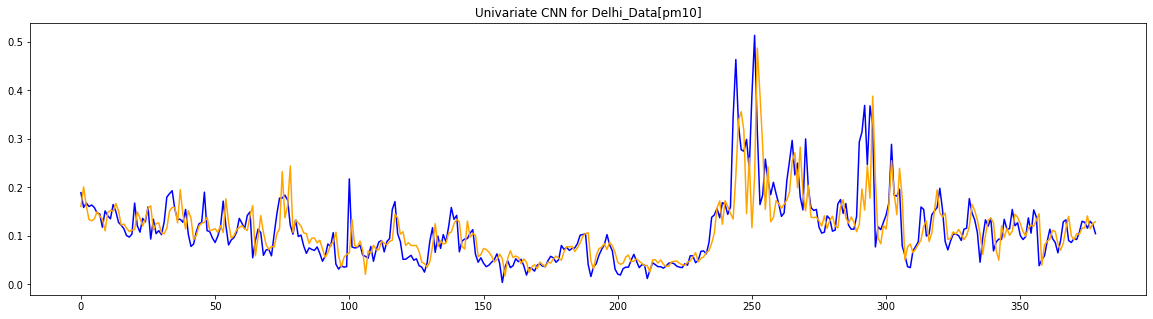

Univariate CNN MSE for Delhi[pm25]:0.004459528
Univariate CNN RMSE for Delhi[pm25]:0.06677969591740536
Univariate CNN MAE for Delhi[pm25]:0.0459619


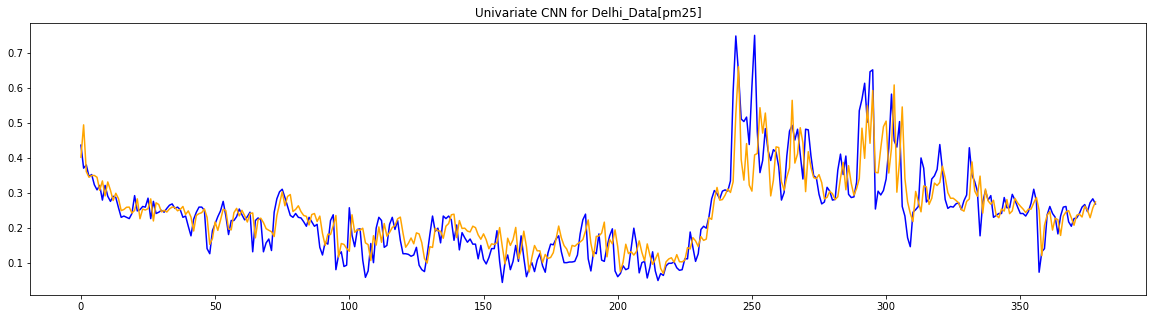

Univariate CNN MSE for Delhi[so2]:0.0019896538
Univariate CNN RMSE for Delhi[so2]:0.04460553552736314
Univariate CNN MAE for Delhi[so2]:0.03169372


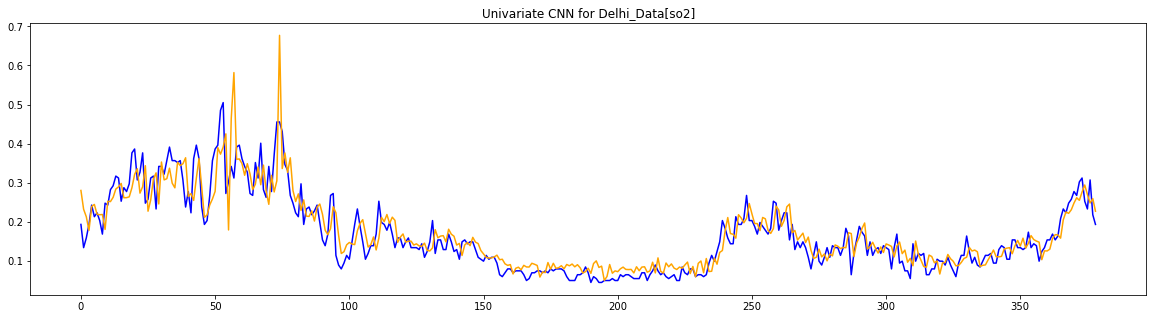

Multivariate CNN MSE for Delhi[o3]:0.00039979868
Multivariate CNN RMSE for Delhi[o3]:0.0199949663340522
Multivariate CNN MAE for Delhi[o3]:0.014684118


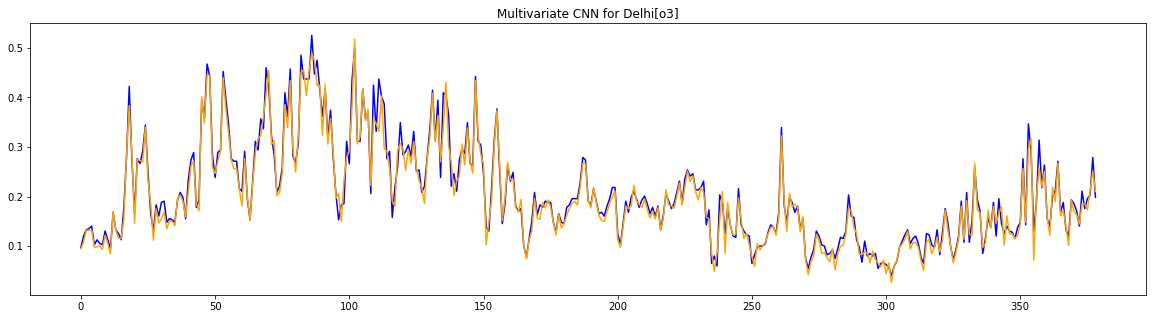

Multivariate CNN MSE for Delhi[no2]:0.00013714895
Multivariate CNN RMSE for Delhi[no2]:0.011711060961841708
Multivariate CNN MAE for Delhi[no2]:0.0093107335


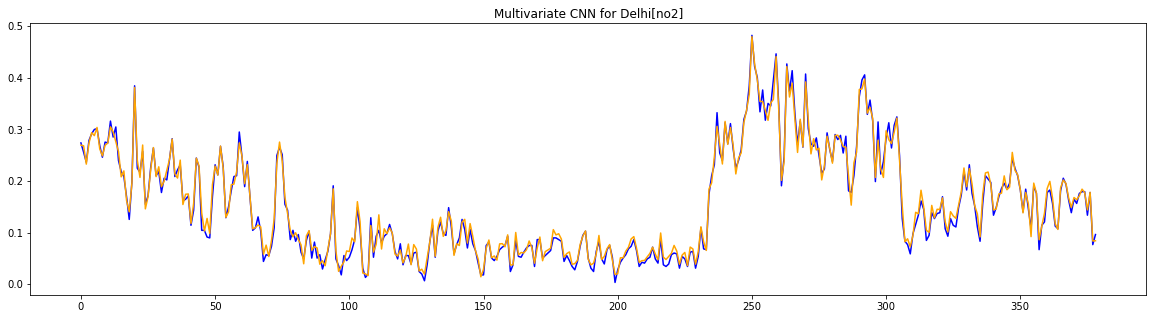

Multivariate CNN MSE for Delhi[so2]:0.0001255821
Multivariate CNN RMSE for Delhi[so2]:0.01120634182497711
Multivariate CNN MAE for Delhi[so2]:0.009060177


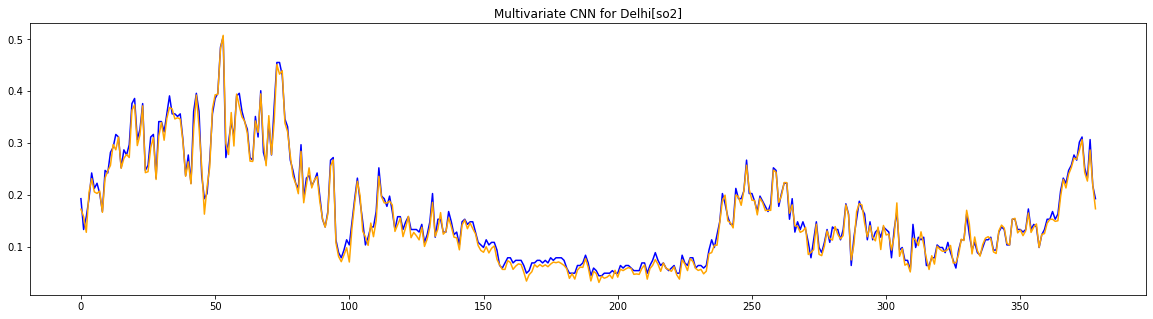

Multivariate CNN MSE for Delhi[pm10]:9.735359e-05
Multivariate CNN RMSE for Delhi[pm10]:0.009866792459878456
Multivariate CNN MAE for Delhi[pm10]:0.007051204


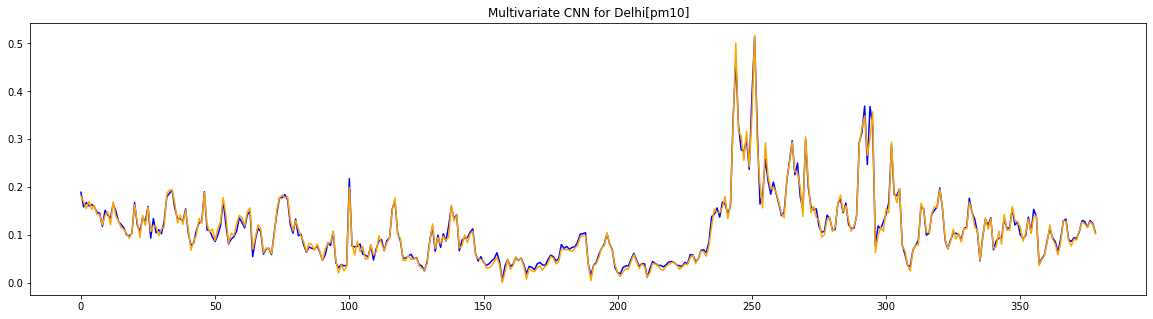

Multivariate CNN MSE for Delhi[pm25]:0.00021058736
Multivariate CNN RMSE for Delhi[pm25]:0.01451162834720126
Multivariate CNN MAE for Delhi[pm25]:0.011543385


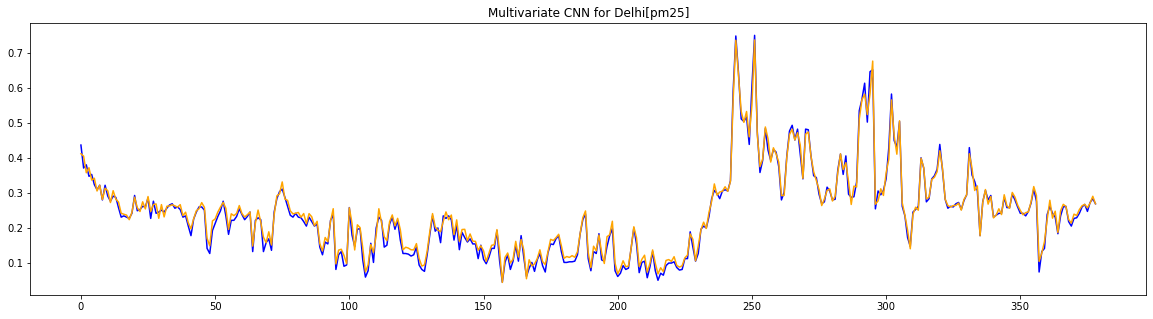

In [18]:
n_steps=7

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()

Univariate LSTM MSE for Delhi[no2]:0.0020507178
Univariate LSTM RMSE for Delhi[no2]:0.04528485206923689
Univariate LSTM MAE for Delhi[no2]:0.03431153


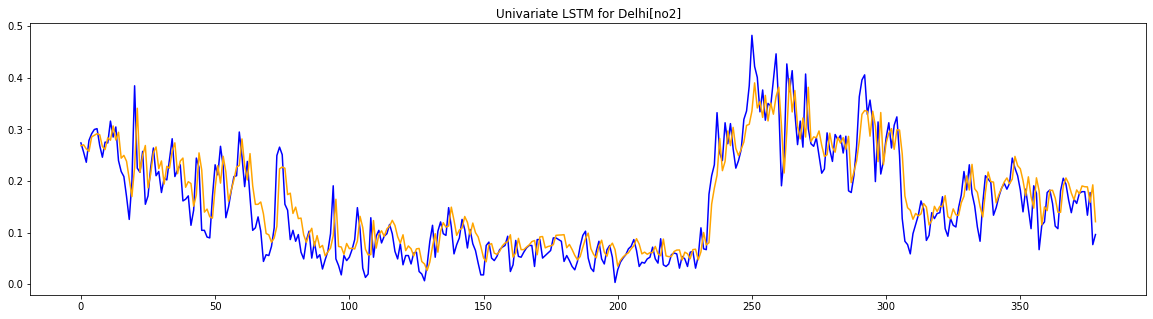

Univariate LSTM MSE for Delhi[o3]:0.0034286436
Univariate LSTM RMSE for Delhi[o3]:0.058554620392845536
Univariate LSTM MAE for Delhi[o3]:0.042974517


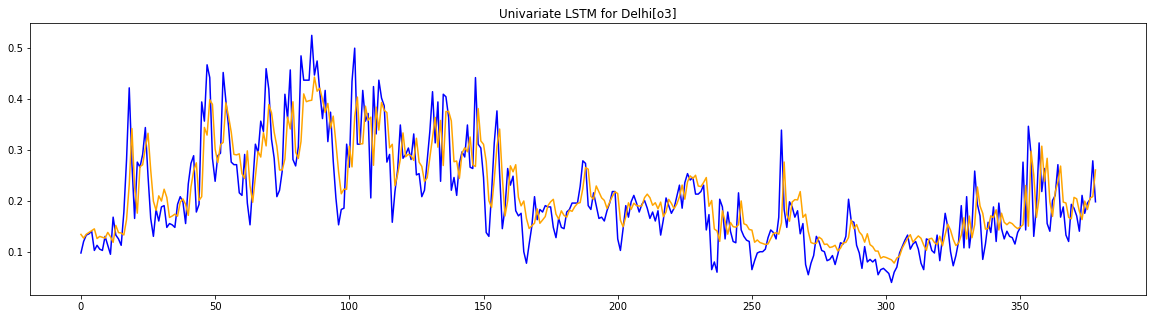

Univariate LSTM MSE for Delhi[pm10]:0.0016002639
Univariate LSTM RMSE for Delhi[pm10]:0.0400032982779568
Univariate LSTM MAE for Delhi[pm10]:0.0257941


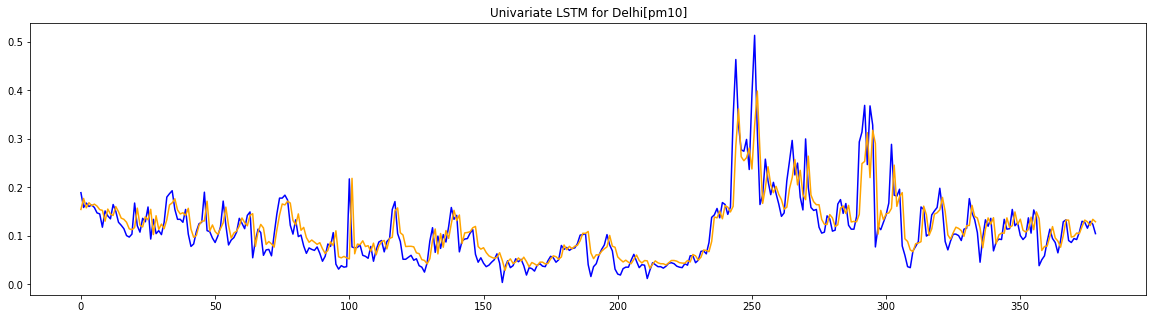

Univariate LSTM MSE for Delhi[pm25]:0.003242119
Univariate LSTM RMSE for Delhi[pm25]:0.05693960820552057
Univariate LSTM MAE for Delhi[pm25]:0.03920514


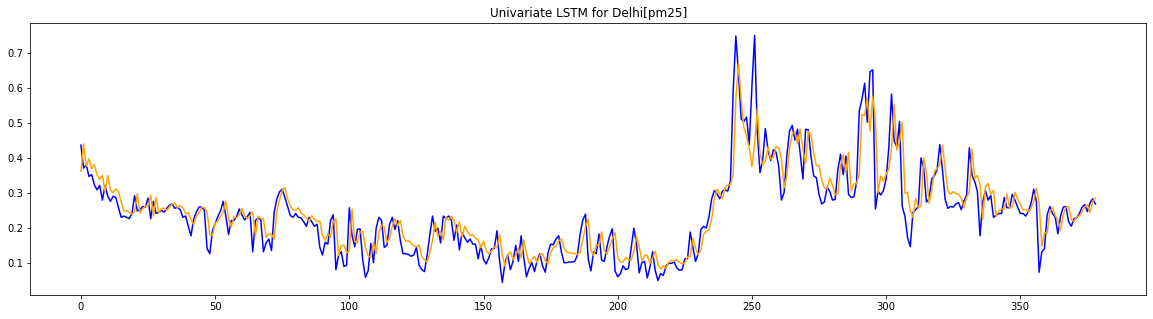

Univariate LSTM MSE for Delhi[so2]:0.0014027882
Univariate LSTM RMSE for Delhi[so2]:0.03745381440459952
Univariate LSTM MAE for Delhi[so2]:0.026385635


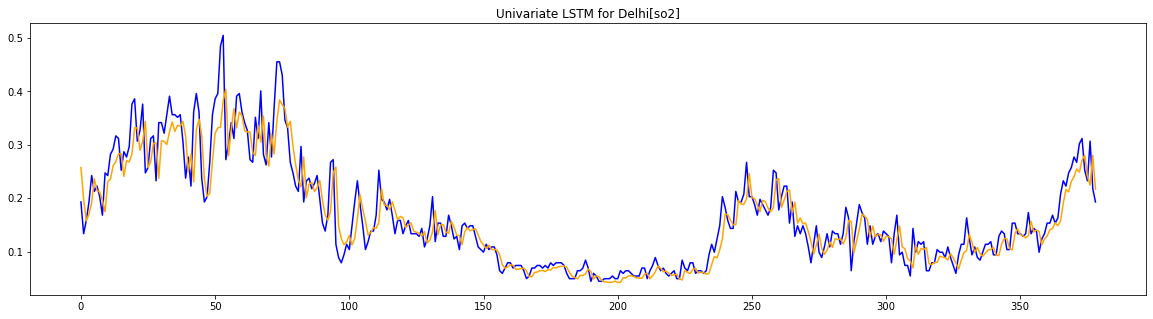

Multivariate LSTM MSE for Delhi[o3]:5.9154895e-06
Multivariate LSTM RMSE for Delhi[o3]:0.0024321779354703967
Multivariate LSTM MAE for Delhi[o3]:0.0020150908


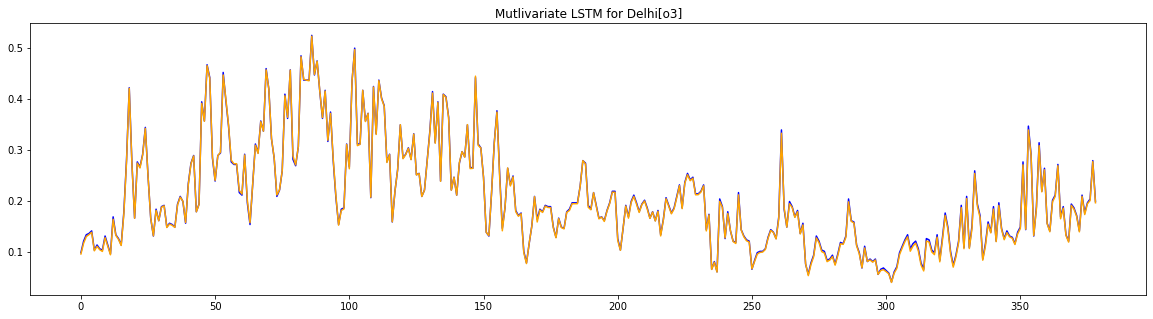

Multivariate LSTM MSE for Delhi[no2]:3.6530514e-06
Multivariate LSTM RMSE for Delhi[no2]:0.0019112957406002989
Multivariate LSTM MAE for Delhi[no2]:0.0015309241


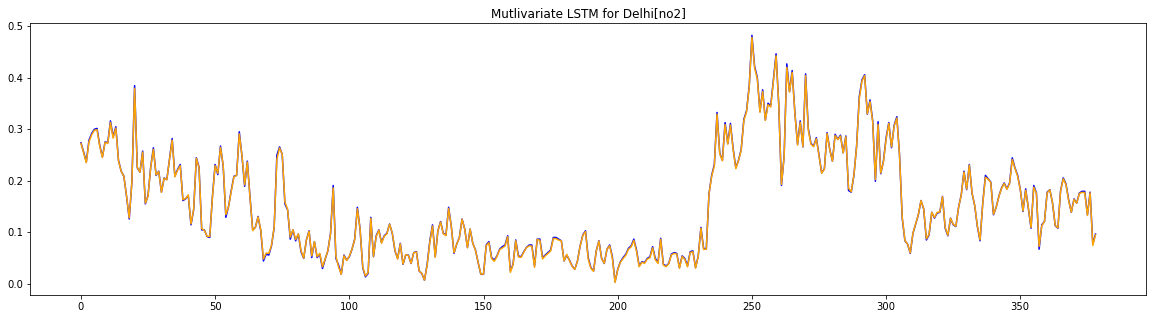

Multivariate LSTM MSE for Delhi[so2]:3.6227466e-06
Multivariate LSTM RMSE for Delhi[so2]:0.001903351409967802
Multivariate LSTM MAE for Delhi[so2]:0.0015536279


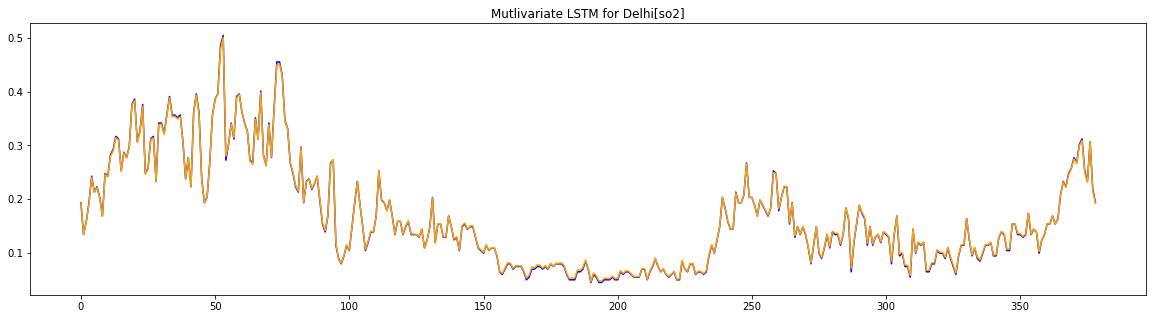

Multivariate LSTM MSE for Delhi[pm10]:1.3343614e-05
Multivariate LSTM RMSE for Delhi[pm10]:0.003652891214884279
Multivariate LSTM MAE for Delhi[pm10]:0.0032964542


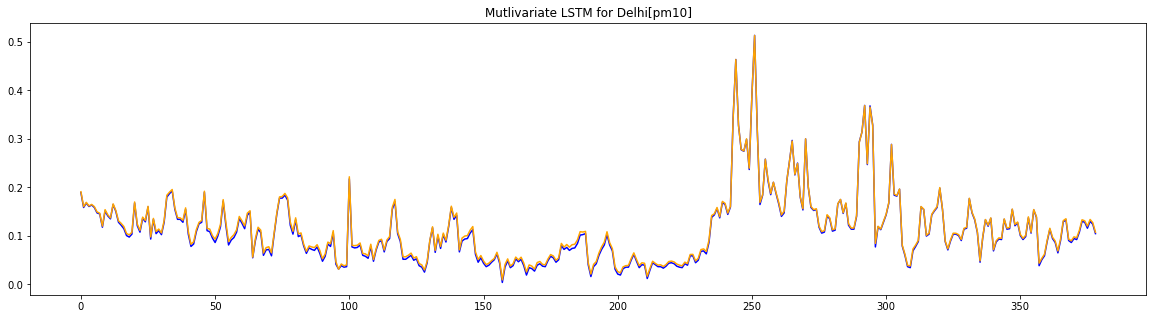

Multivariate LSTM MSE for Delhi[pm25]:4.8569982e-05
Multivariate LSTM RMSE for Delhi[pm25]:0.006969216744183104
Multivariate LSTM MAE for Delhi[pm25]:0.006779365


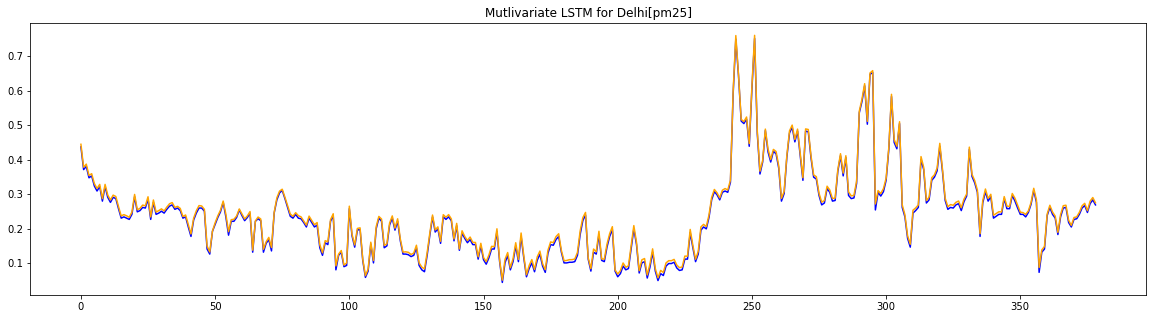

In [19]:
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Weekly seasonal predictions

In [20]:
Delhi_Data_uni.index = pd.to_datetime(Delhi_Data_uni.index)
Delhi_Data_uni = Delhi_Data_uni.resample("1w").mean().bfill()

Delhi_o3.index = pd.to_datetime(Delhi_o3.index)
Delhi_weekly_o3 = Delhi_o3.resample("1w").mean().bfill()

Delhi_no2.index = pd.to_datetime(Delhi_no2.index)
Delhi_weekly_no2 = Delhi_no2.resample("1w").mean().bfill()

Delhi_so2.index = pd.to_datetime(Delhi_so2.index)
Delhi_weekly_so2 = Delhi_so2.resample("1w").mean().bfill()

Delhi_pm10.index = pd.to_datetime(Delhi_pm10.index)
Delhi_weekly_pm10 = Delhi_pm10.resample("1w").mean().bfill()

Delhi_pm25.index = pd.to_datetime(Delhi_pm25.index)
Delhi_weekly_pm25 = Delhi_pm25.resample("1w").mean().bfill()

datasets = [Delhi_weekly_o3.iloc[1: , :], Delhi_weekly_no2.iloc[1: , :], 
            Delhi_weekly_so2.iloc[1: , :], Delhi_weekly_pm10.iloc[1: , :],
            Delhi_weekly_pm25.iloc[1: , :]]


Univariate CNN MSE for Delhi[no2]:0.00463561
Univariate CNN RMSE for Delhi[no2]:0.06808531524518302
Univariate CNN MAE for Delhi[no2]:0.054793313


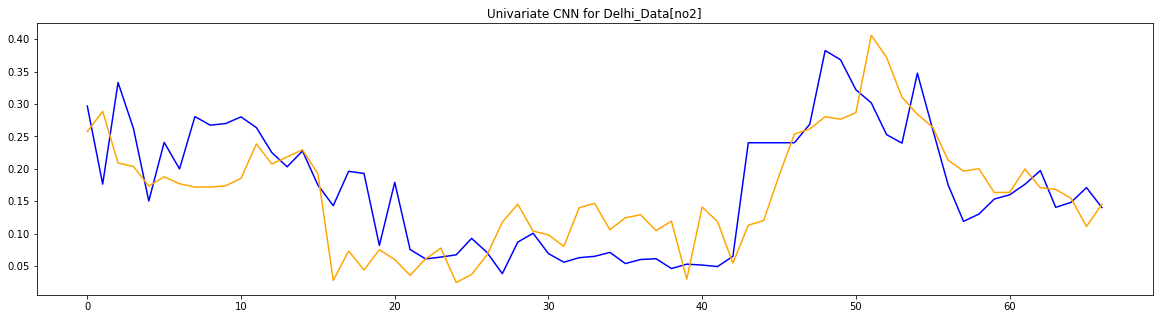

Univariate CNN MSE for Delhi[o3]:0.0029286046
Univariate CNN RMSE for Delhi[o3]:0.05411658345346984
Univariate CNN MAE for Delhi[o3]:0.03993241


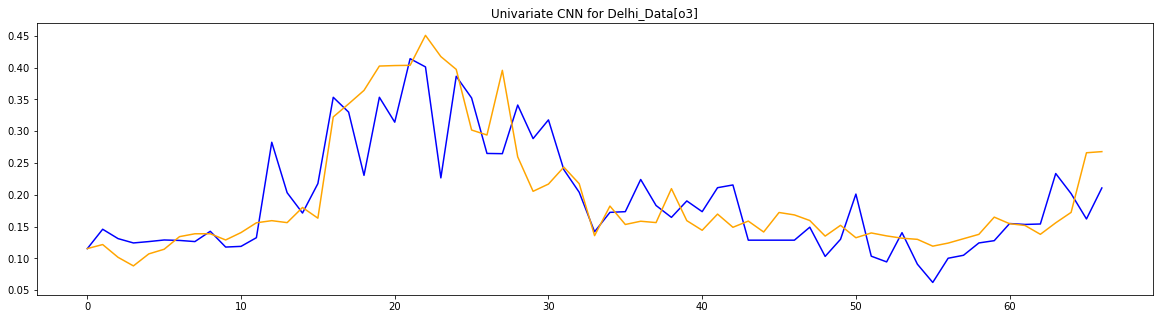

Univariate CNN MSE for Delhi[pm10]:0.0022904102
Univariate CNN RMSE for Delhi[pm10]:0.04785823045710802
Univariate CNN MAE for Delhi[pm10]:0.03472524


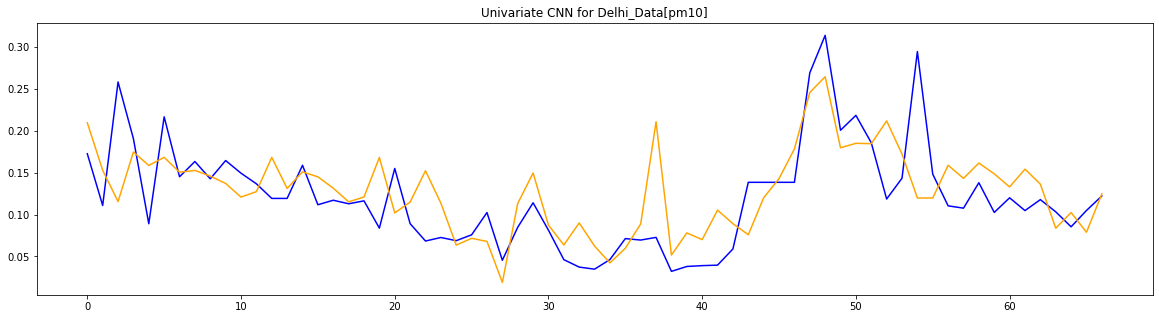

Univariate CNN MSE for Delhi[pm25]:0.0062235366
Univariate CNN RMSE for Delhi[pm25]:0.0788893944847757
Univariate CNN MAE for Delhi[pm25]:0.05796921


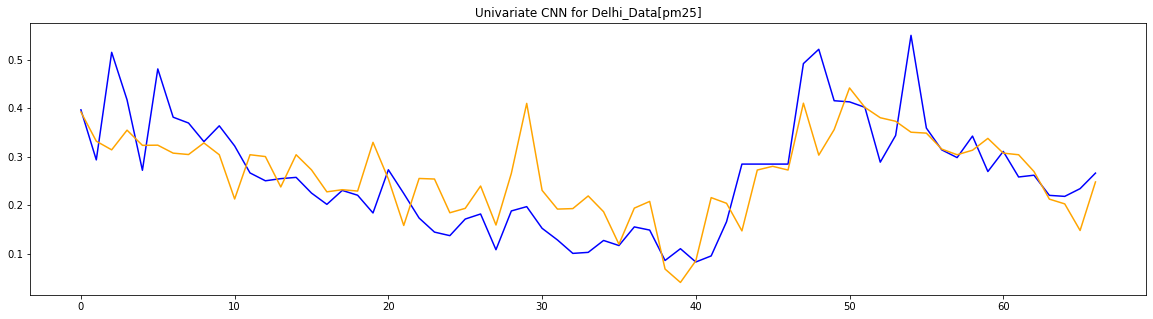

Univariate CNN MSE for Delhi[so2]:0.006015212
Univariate CNN RMSE for Delhi[so2]:0.0775577965740811
Univariate CNN MAE for Delhi[so2]:0.064700566


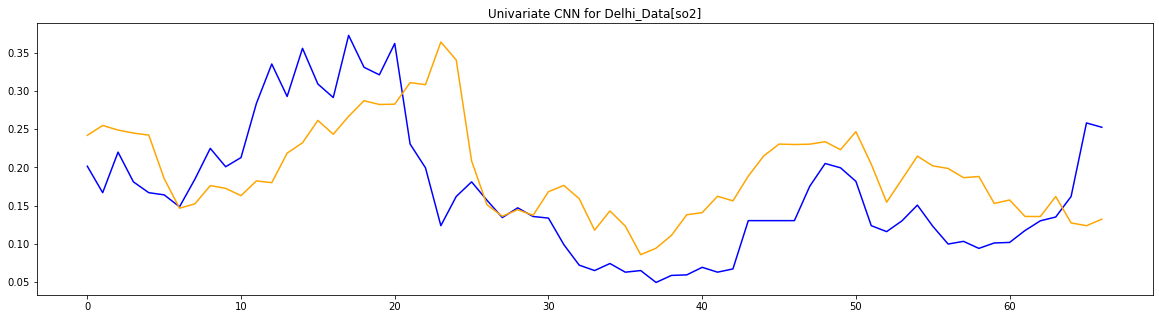

Multivariate CNN MSE for Delhi[o3]:0.008187962
Multivariate CNN RMSE for Delhi[o3]:0.0904873569325221
Multivariate CNN MAE for Delhi[o3]:0.074656636


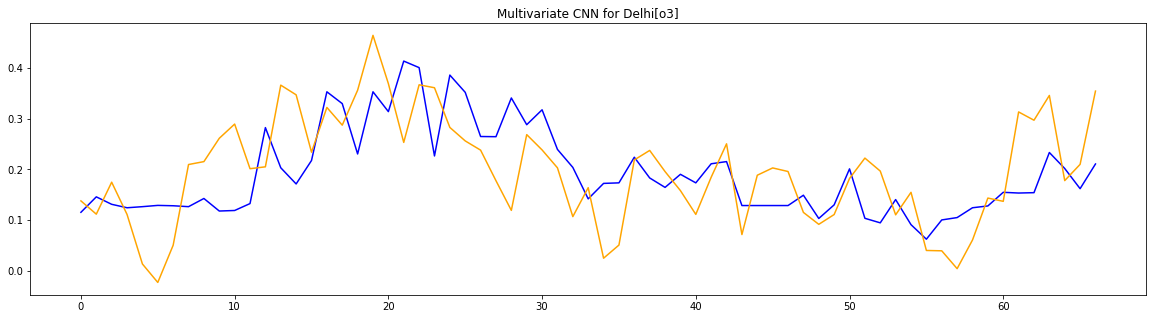

Multivariate CNN MSE for Delhi[no2]:0.0077745477
Multivariate CNN RMSE for Delhi[no2]:0.08817339549865279
Multivariate CNN MAE for Delhi[no2]:0.07045368


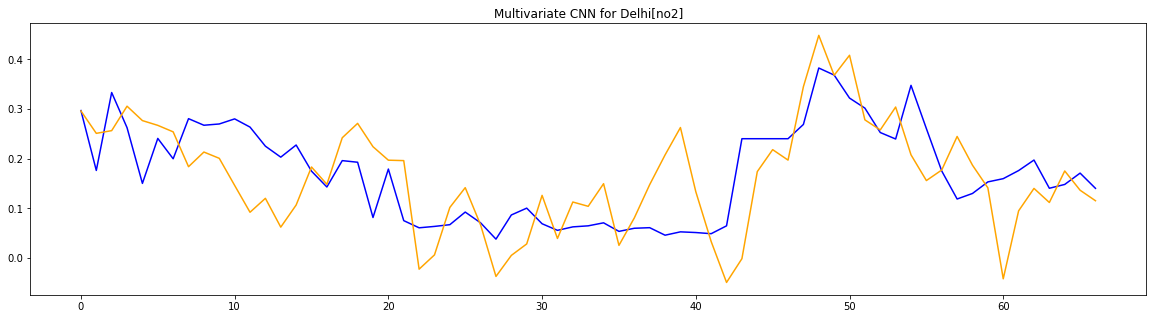

Multivariate CNN MSE for Delhi[so2]:0.007916123
Multivariate CNN RMSE for Delhi[so2]:0.08897259507815886
Multivariate CNN MAE for Delhi[so2]:0.06922051


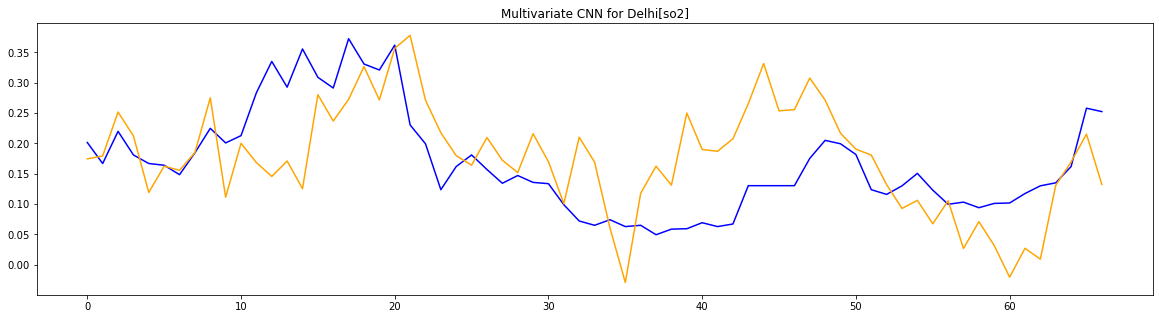

Multivariate CNN MSE for Delhi[pm10]:0.008350954
Multivariate CNN RMSE for Delhi[pm10]:0.09138355645881954
Multivariate CNN MAE for Delhi[pm10]:0.076210745


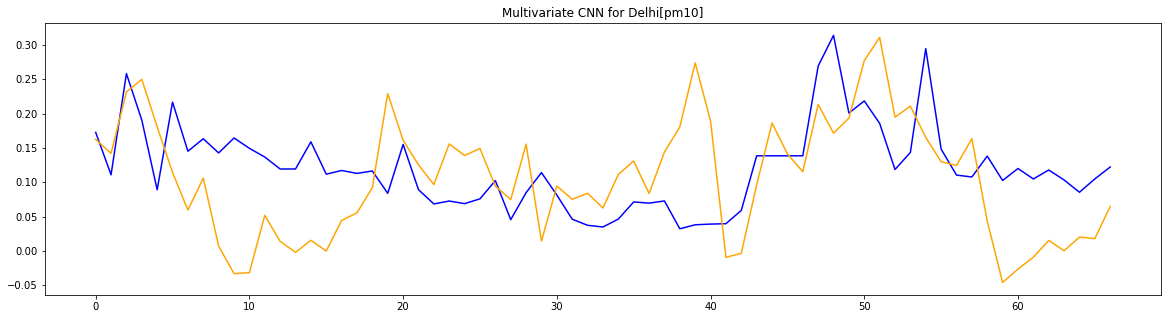

Multivariate CNN MSE for Delhi[pm25]:0.009216386
Multivariate CNN RMSE for Delhi[pm25]:0.0960020098410637
Multivariate CNN MAE for Delhi[pm25]:0.07906433


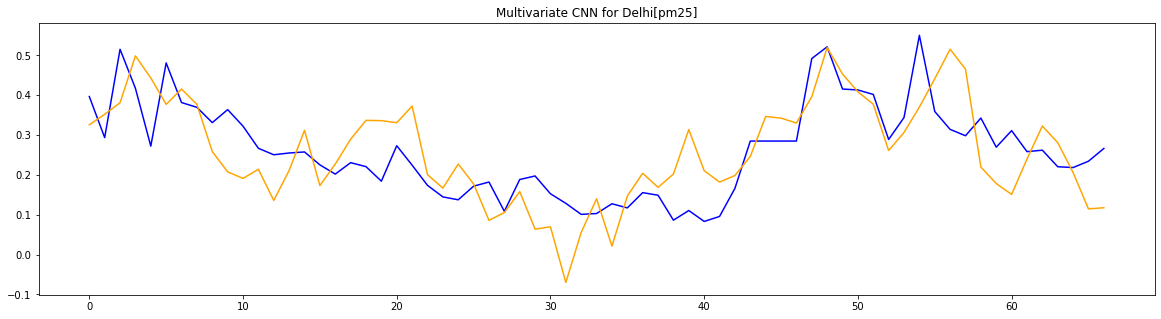

Univariate LSTM MSE for Delhi[no2]:0.0029739388
Univariate LSTM RMSE for Delhi[no2]:0.054533831943771996
Univariate LSTM MAE for Delhi[no2]:0.04066126


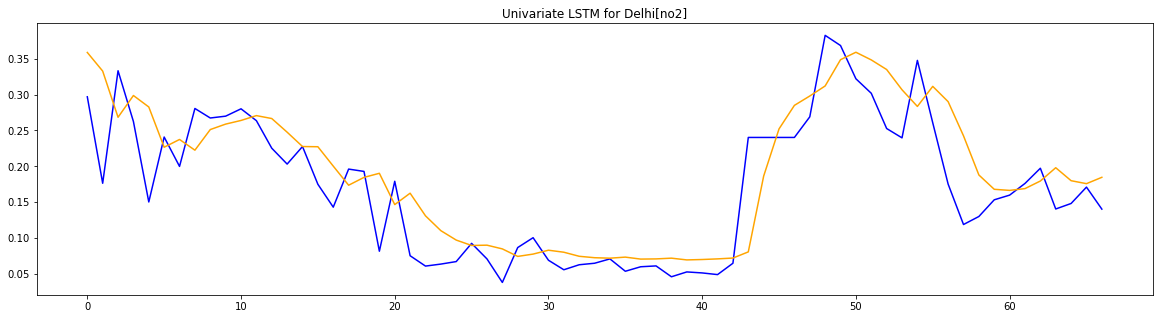

Univariate LSTM MSE for Delhi[o3]:0.00217092
Univariate LSTM RMSE for Delhi[o3]:0.046593131536182344
Univariate LSTM MAE for Delhi[o3]:0.03290442


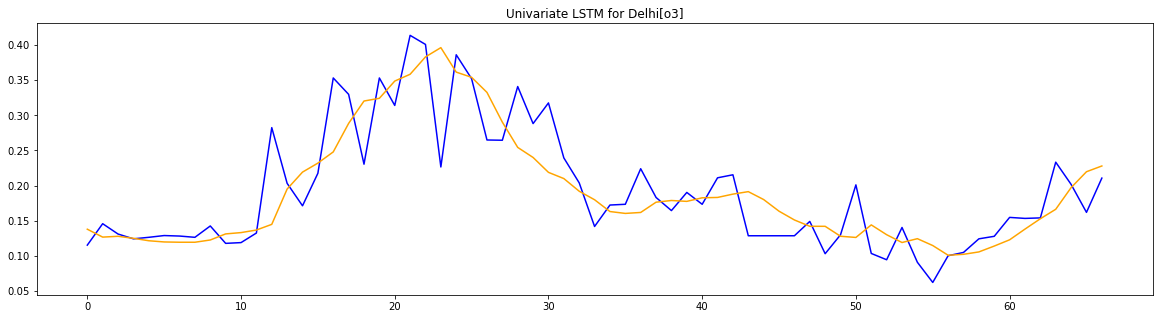

Univariate LSTM MSE for Delhi[pm10]:0.0020564466
Univariate LSTM RMSE for Delhi[pm10]:0.04534806087276249
Univariate LSTM MAE for Delhi[pm10]:0.033461828


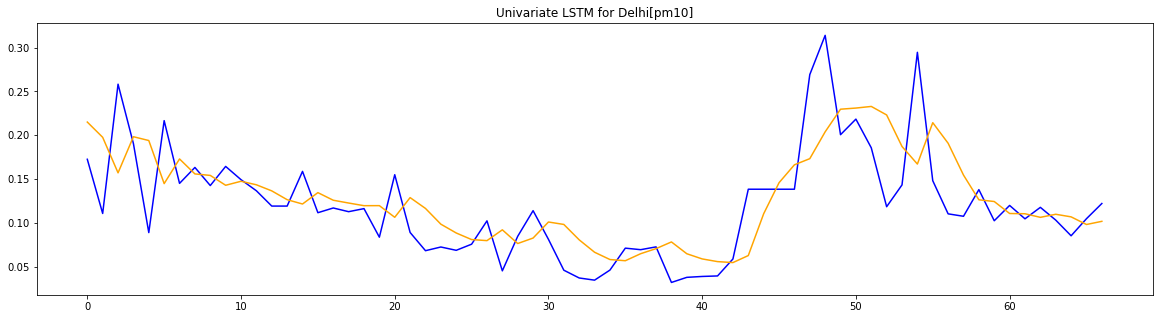

Univariate LSTM MSE for Delhi[pm25]:0.004021095
Univariate LSTM RMSE for Delhi[pm25]:0.06341210540556222
Univariate LSTM MAE for Delhi[pm25]:0.04646191


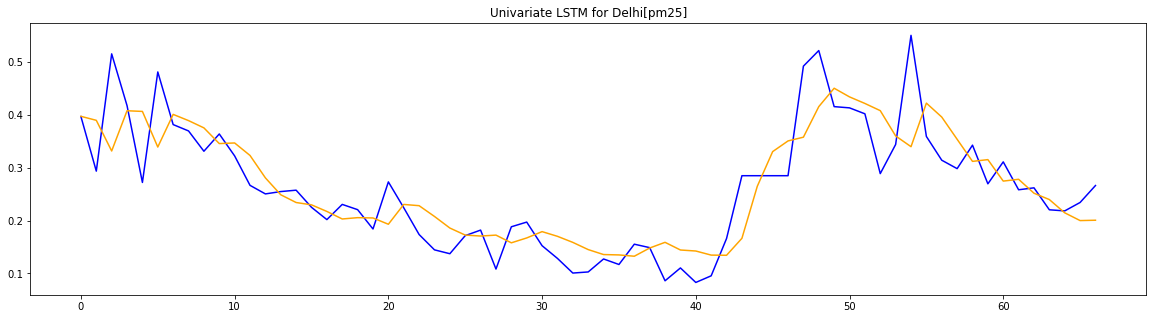

Univariate LSTM MSE for Delhi[so2]:0.0018327174
Univariate LSTM RMSE for Delhi[so2]:0.04281024932818839
Univariate LSTM MAE for Delhi[so2]:0.034764044


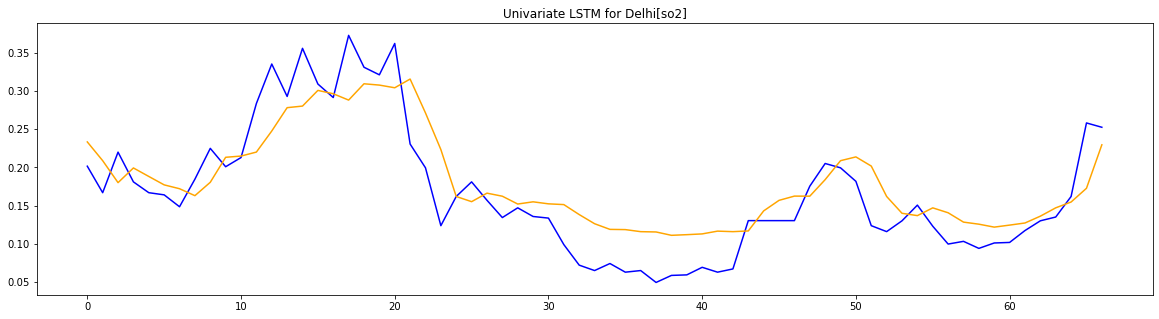

Multivariate LSTM MSE for Delhi[o3]:0.00015672535
Multivariate LSTM RMSE for Delhi[o3]:0.012518999535521606
Multivariate LSTM MAE for Delhi[o3]:0.010796055


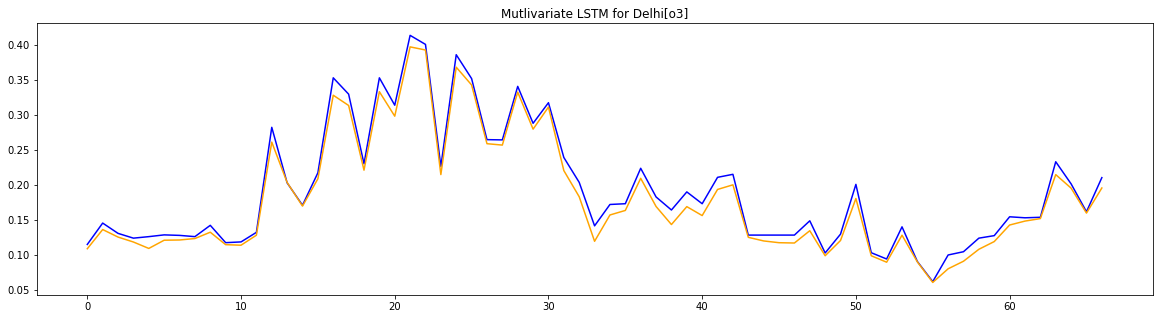

Multivariate LSTM MSE for Delhi[no2]:6.15126e-05
Multivariate LSTM RMSE for Delhi[no2]:0.00784299670487532
Multivariate LSTM MAE for Delhi[no2]:0.006341521


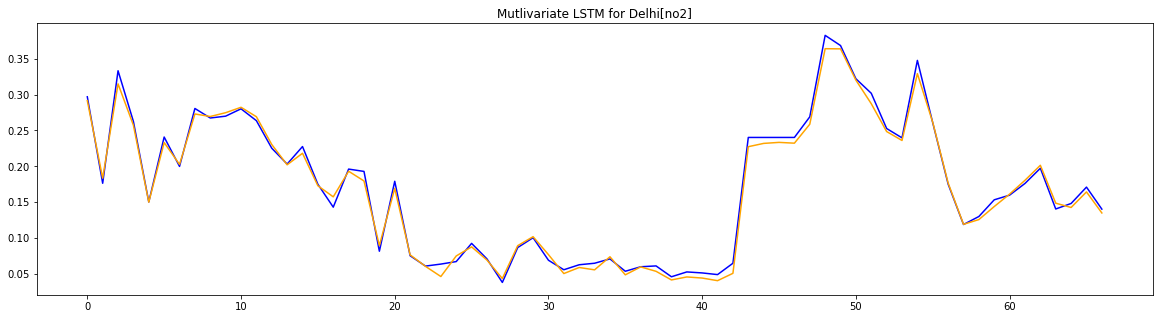

Multivariate LSTM MSE for Delhi[so2]:6.321202e-05
Multivariate LSTM RMSE for Delhi[so2]:0.007950598776492063
Multivariate LSTM MAE for Delhi[so2]:0.0060590515


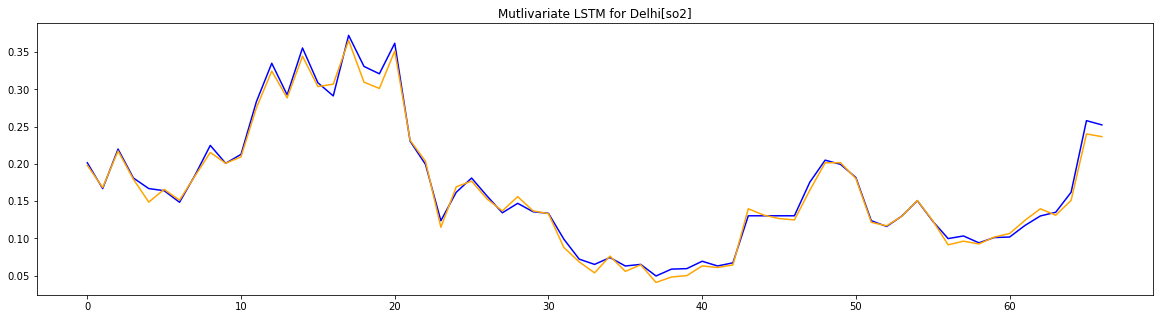

Multivariate LSTM MSE for Delhi[pm10]:8.140216e-05
Multivariate LSTM RMSE for Delhi[pm10]:0.00902231468763834
Multivariate LSTM MAE for Delhi[pm10]:0.008301255


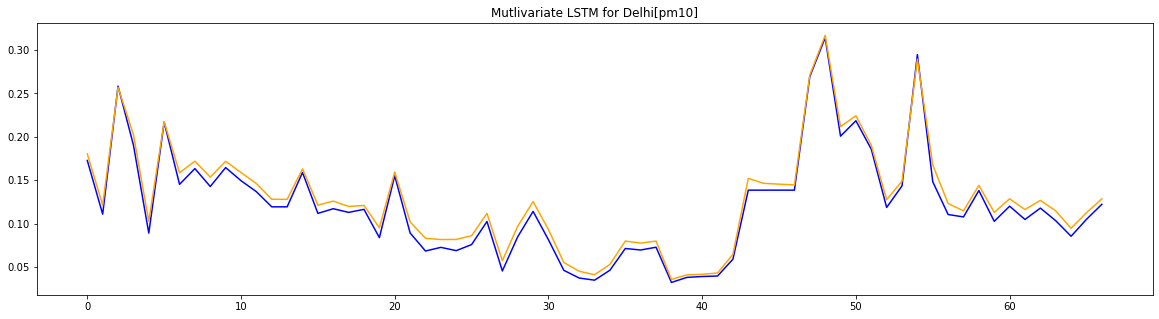

Multivariate LSTM MSE for Delhi[pm25]:0.00031099506
Multivariate LSTM RMSE for Delhi[pm25]:0.01763505211350376
Multivariate LSTM MAE for Delhi[pm25]:0.015796091


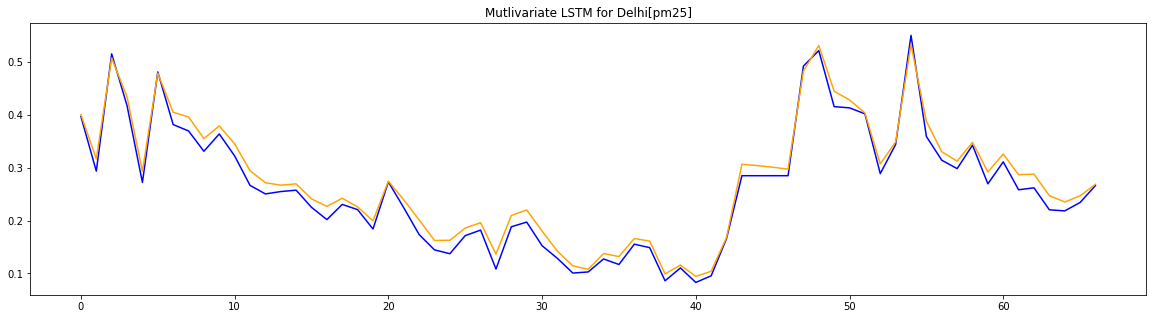

In [21]:
n_steps = 42

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Monthly seasonal predictions

In [22]:
Delhi_Data_uni.index = pd.to_datetime(Delhi_Data_uni.index)
Delhi_Data_uni = Delhi_Data_uni.resample("1m").mean().bfill()

In [23]:
Delhi_o3.index = pd.to_datetime(Delhi_o3.index)
Delhi_monthly_o3 = Delhi_o3.resample("1m").mean().bfill()

Delhi_no2.index = pd.to_datetime(Delhi_no2.index)
Delhi_monthly_no2 = Delhi_no2.resample("1m").mean().bfill()

Delhi_so2.index = pd.to_datetime(Delhi_so2.index)
Delhi_monthly_so2 = Delhi_so2.resample("1m").mean().bfill()

Delhi_pm10.index = pd.to_datetime(Delhi_pm10.index)
Delhi_monthly_pm10 = Delhi_pm10.resample("1m").mean().bfill()

Delhi_pm25.index = pd.to_datetime(Delhi_pm25.index)
Delhi_monthly_pm25 = Delhi_pm25.resample("1m").mean().bfill()

datasets = [Delhi_monthly_o3.iloc[1: , :], Delhi_monthly_no2.iloc[1: , :], 
            Delhi_monthly_so2.iloc[1: , :], Delhi_monthly_pm10.iloc[1: , :],
            Delhi_monthly_pm25.iloc[1: , :]]

Univariate CNN MSE for Delhi[no2]:0.010481411
Univariate CNN RMSE for Delhi[no2]:0.10237876078488958
Univariate CNN MAE for Delhi[no2]:0.07119439


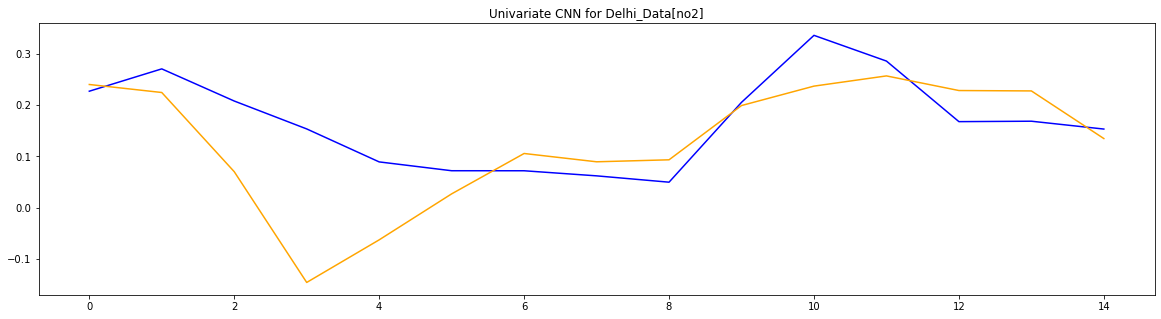

Univariate CNN MSE for Delhi[o3]:0.0009069614
Univariate CNN RMSE for Delhi[o3]:0.030115799639967262
Univariate CNN MAE for Delhi[o3]:0.023771973


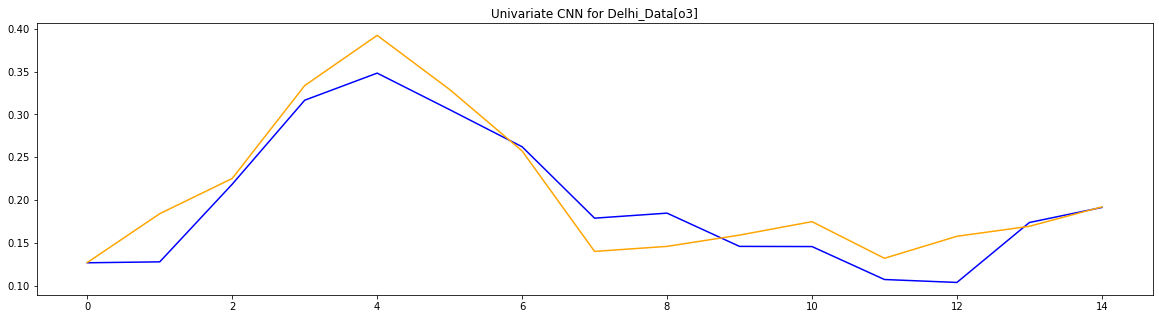

Univariate CNN MSE for Delhi[pm10]:0.0016091651
Univariate CNN RMSE for Delhi[pm10]:0.04011440022033722
Univariate CNN MAE for Delhi[pm10]:0.031679474


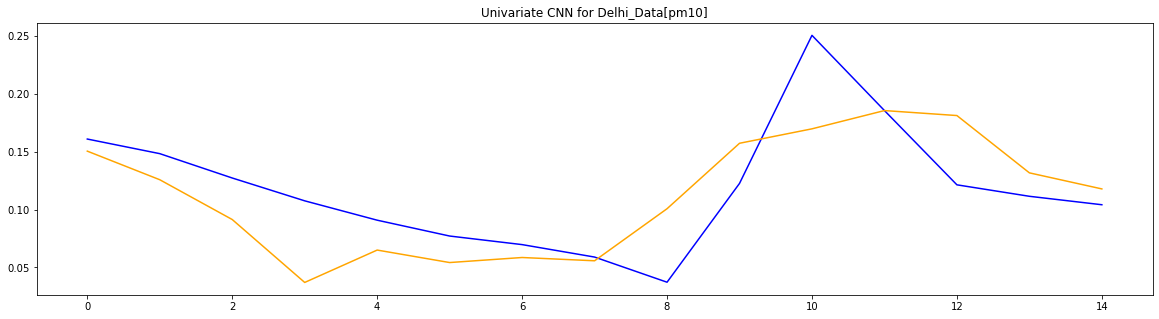

Univariate CNN MSE for Delhi[pm25]:0.002235923
Univariate CNN RMSE for Delhi[pm25]:0.04728554707759168
Univariate CNN MAE for Delhi[pm25]:0.037264705


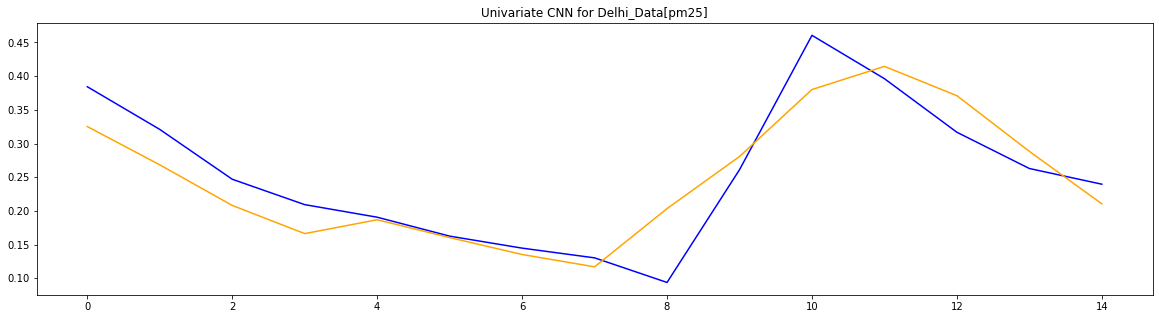

Univariate CNN MSE for Delhi[so2]:0.0128787095
Univariate CNN RMSE for Delhi[so2]:0.11348440189169547
Univariate CNN MAE for Delhi[so2]:0.080001734


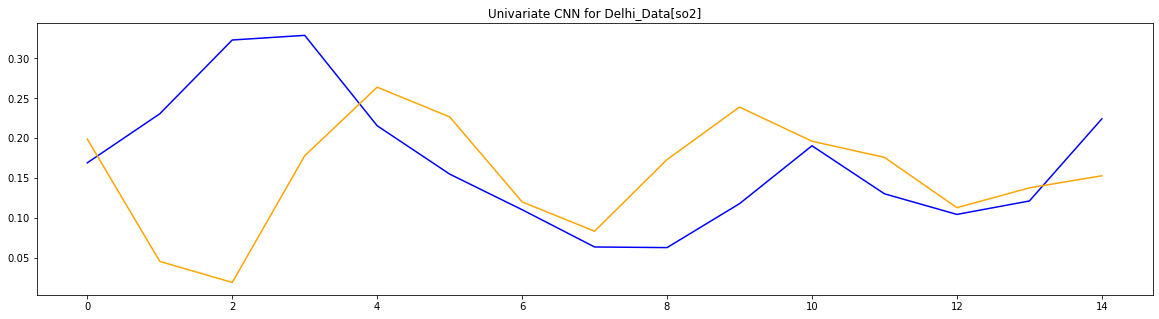

Multivariate CNN MSE for Delhi[o3]:0.0022477426
Multivariate CNN RMSE for Delhi[o3]:0.047410363951906426
Multivariate CNN MAE for Delhi[o3]:0.03458352


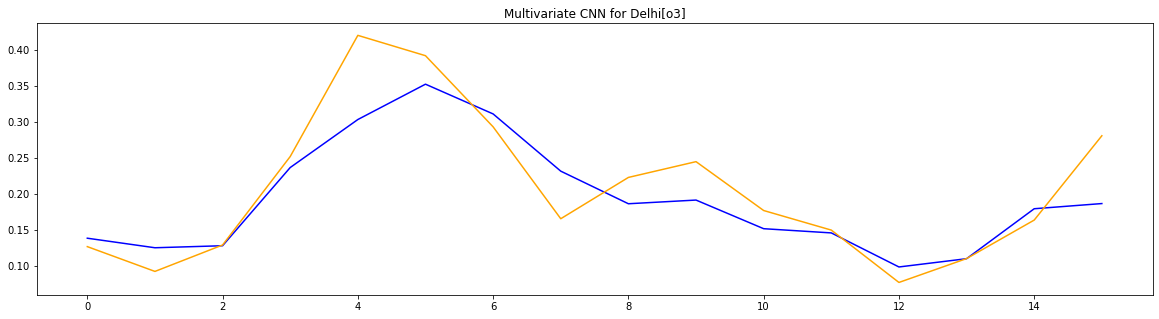

Multivariate CNN MSE for Delhi[no2]:0.0047300286
Multivariate CNN RMSE for Delhi[no2]:0.06877520313291008
Multivariate CNN MAE for Delhi[no2]:0.05820124


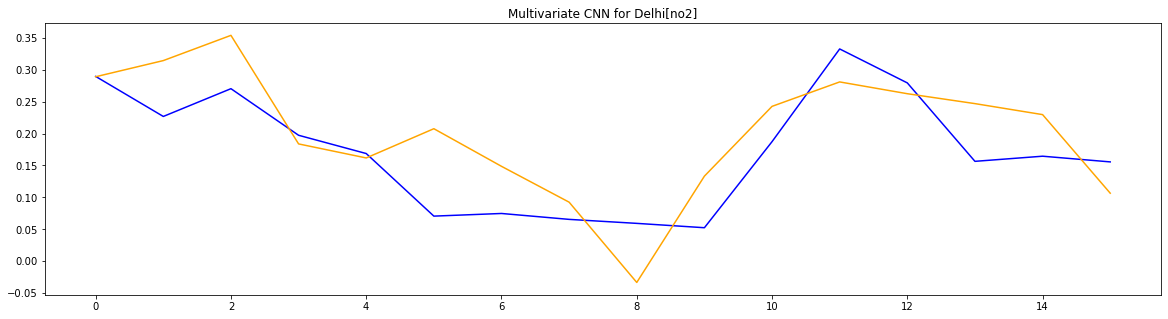

Multivariate CNN MSE for Delhi[so2]:0.0036824723
Multivariate CNN RMSE for Delhi[so2]:0.06068337727444543
Multivariate CNN MAE for Delhi[so2]:0.04839772


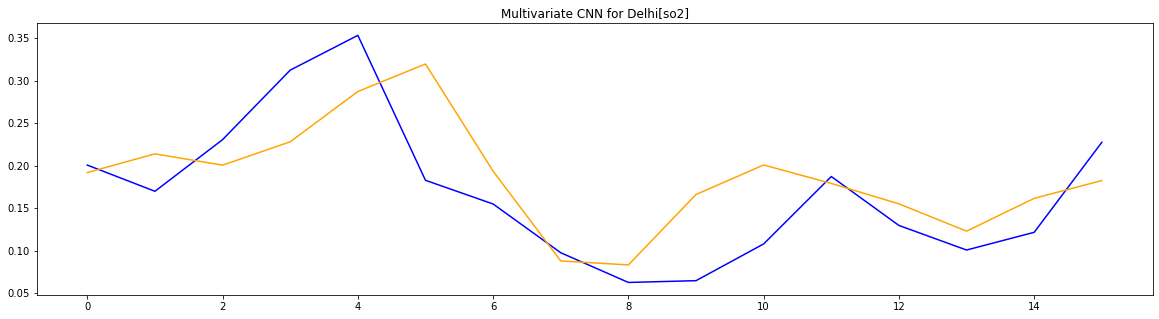

Multivariate CNN MSE for Delhi[pm10]:0.0033400585
Multivariate CNN RMSE for Delhi[pm10]:0.057793239175177355
Multivariate CNN MAE for Delhi[pm10]:0.051577605


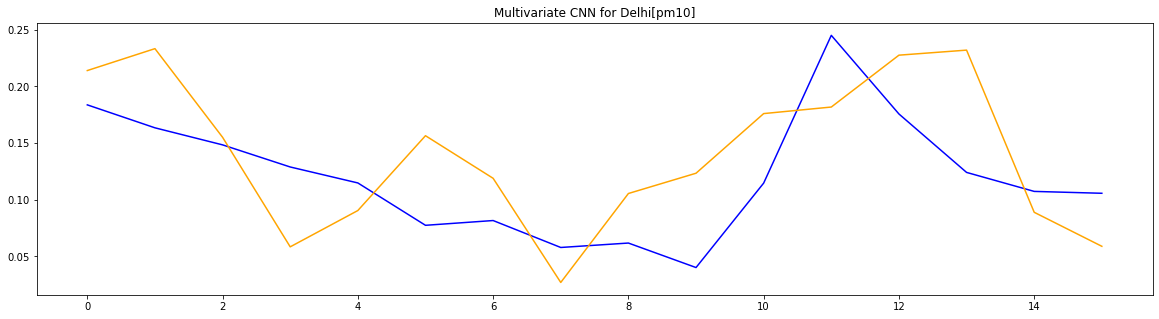

Multivariate CNN MSE for Delhi[pm25]:0.006814326
Multivariate CNN RMSE for Delhi[pm25]:0.08254893191105532
Multivariate CNN MAE for Delhi[pm25]:0.061906703


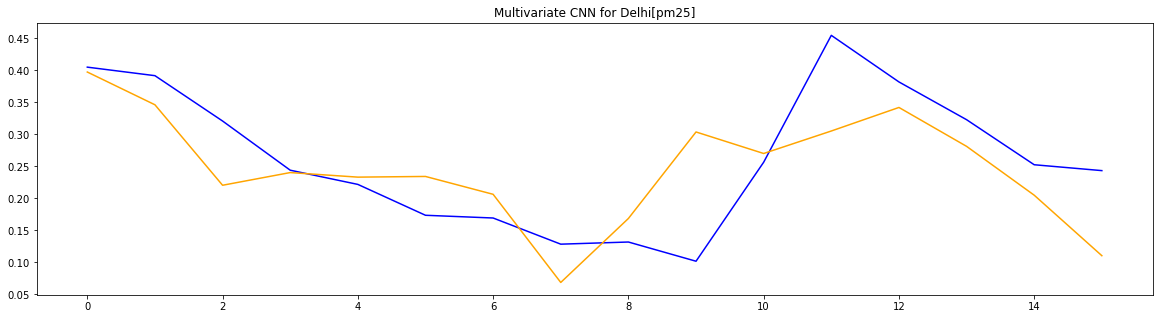

Univariate LSTM MSE for Delhi[no2]:0.00792573
Univariate LSTM RMSE for Delhi[no2]:0.08902657018341069
Univariate LSTM MAE for Delhi[no2]:0.07690921


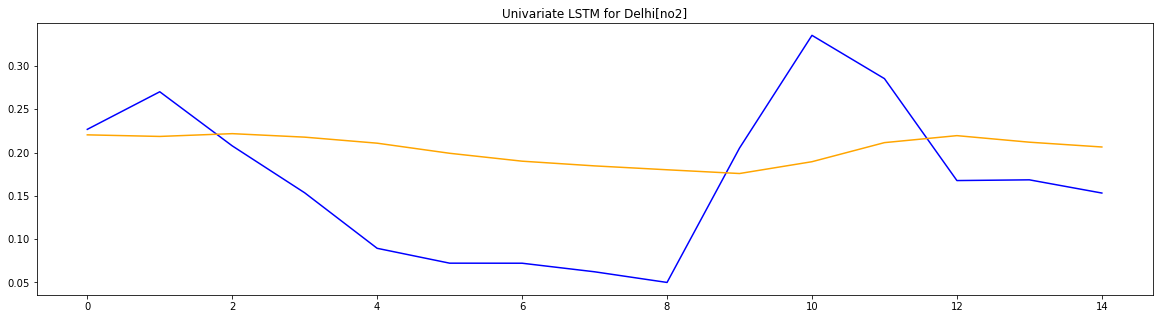

Univariate LSTM MSE for Delhi[o3]:0.0006402737
Univariate LSTM RMSE for Delhi[o3]:0.025303629705120474
Univariate LSTM MAE for Delhi[o3]:0.020298004


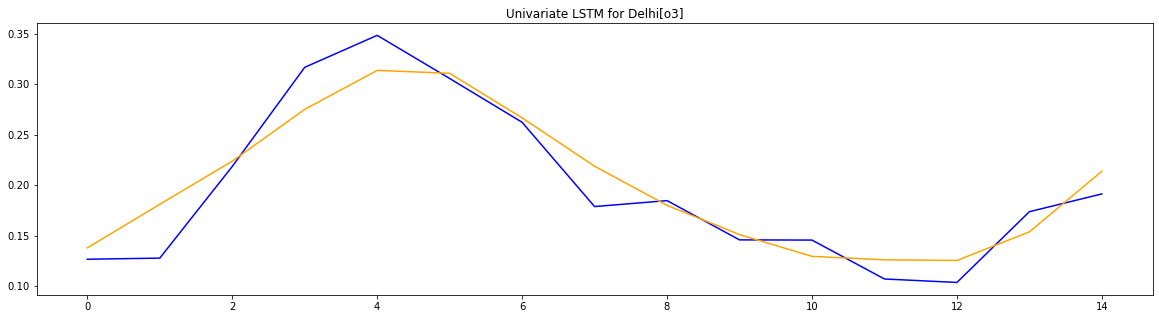

Univariate LSTM MSE for Delhi[pm10]:0.0029656542
Univariate LSTM RMSE for Delhi[pm10]:0.05445782080205813
Univariate LSTM MAE for Delhi[pm10]:0.0481275


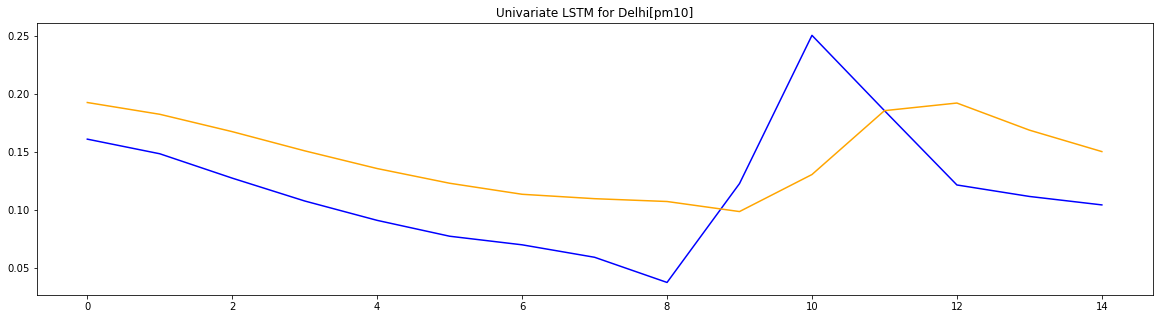

Univariate LSTM MSE for Delhi[pm25]:0.005715248
Univariate LSTM RMSE for Delhi[pm25]:0.07559926041282006
Univariate LSTM MAE for Delhi[pm25]:0.06486092


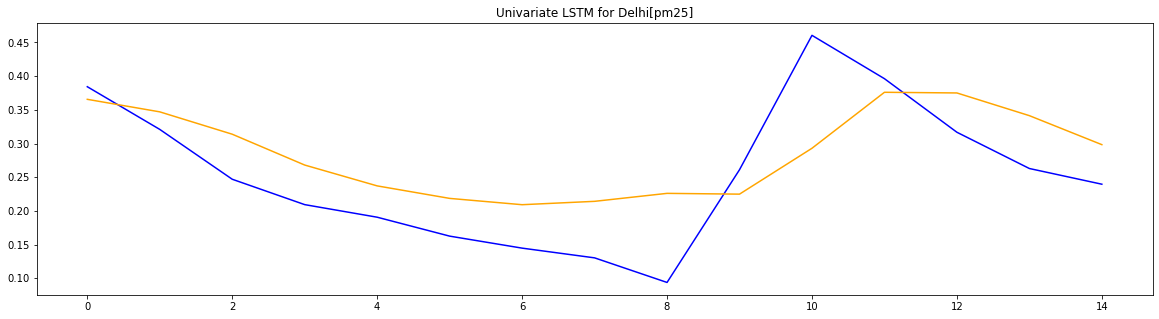

Univariate LSTM MSE for Delhi[so2]:0.0059948904
Univariate LSTM RMSE for Delhi[so2]:0.0774266772556361
Univariate LSTM MAE for Delhi[so2]:0.06964127


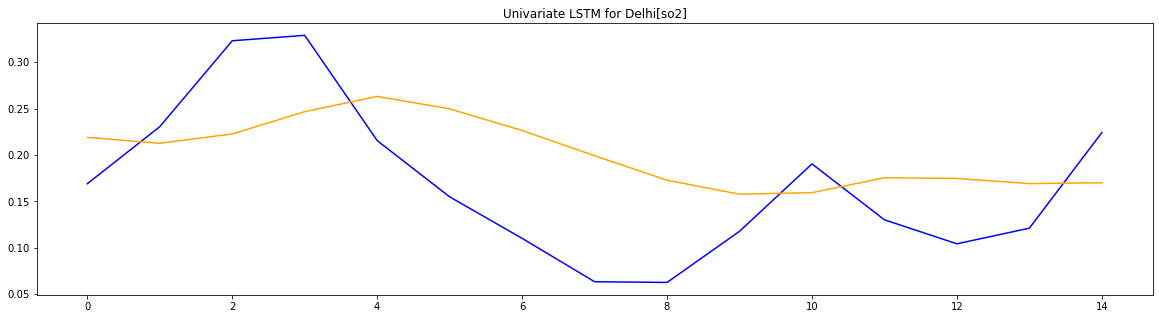

Multivariate LSTM MSE for Delhi[o3]:0.0008444857
Multivariate LSTM RMSE for Delhi[o3]:0.029060036278579657
Multivariate LSTM MAE for Delhi[o3]:0.022647068


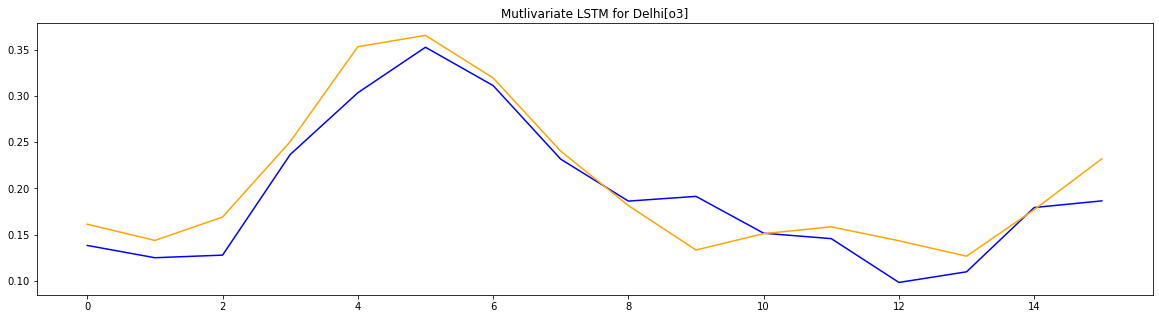

Multivariate LSTM MSE for Delhi[no2]:0.0010054626
Multivariate LSTM RMSE for Delhi[no2]:0.03170903031698599
Multivariate LSTM MAE for Delhi[no2]:0.028584404


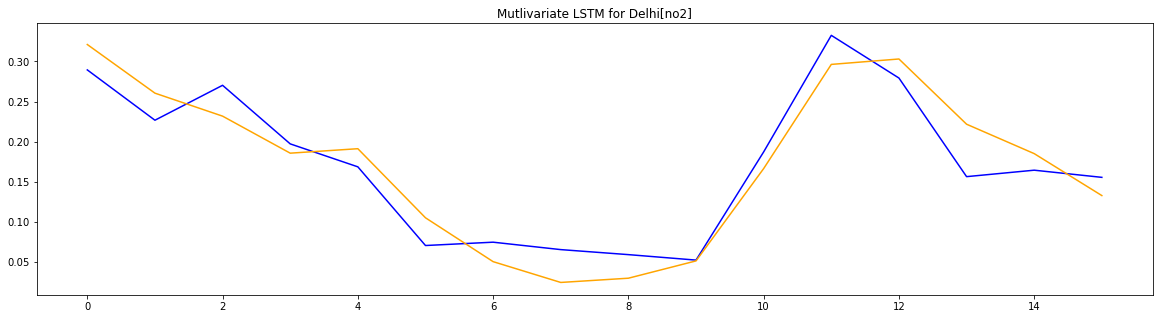

Multivariate LSTM MSE for Delhi[so2]:0.0019060615
Multivariate LSTM RMSE for Delhi[so2]:0.04365846475787234
Multivariate LSTM MAE for Delhi[so2]:0.037700728


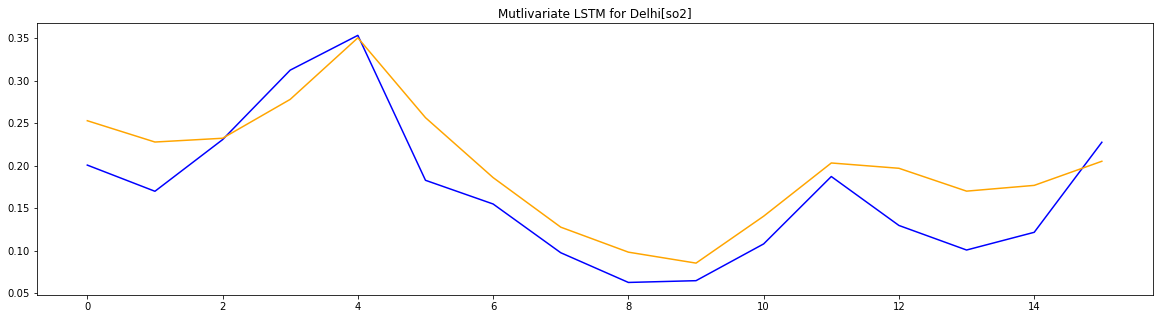

Multivariate LSTM MSE for Delhi[pm10]:0.00054914434
Multivariate LSTM RMSE for Delhi[pm10]:0.023433829059808807
Multivariate LSTM MAE for Delhi[pm10]:0.021445235


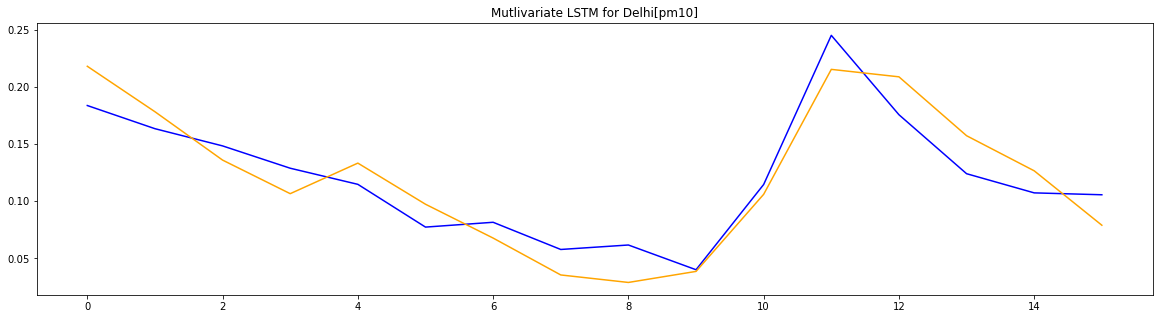

Multivariate LSTM MSE for Delhi[pm25]:0.001182809
Multivariate LSTM RMSE for Delhi[pm25]:0.03439199043996666
Multivariate LSTM MAE for Delhi[pm25]:0.029391402


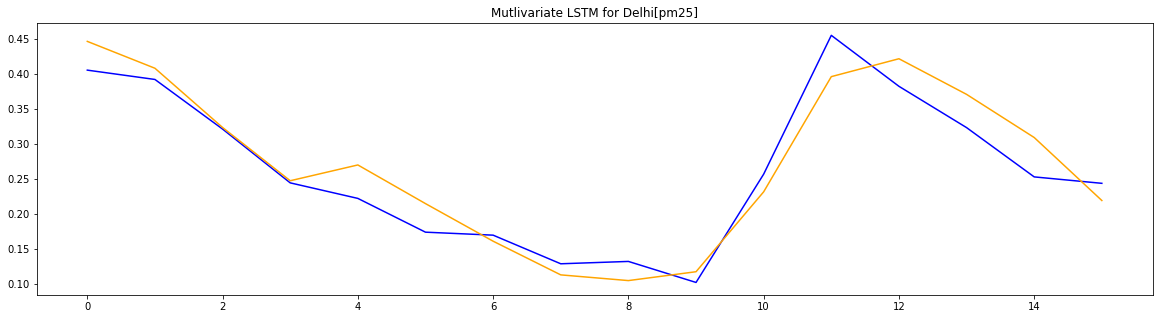

In [24]:
n_steps = 12

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()